# Molecular dynamics simulations fundamentals
Molecular dynamics simulations model atomic motion using classical laws of physics. In this workshop we will write a python program to simulate a 2D liquid. 

## Simulation setup

### Set up python

In [1]:
import numpy as np #import useful modules
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### Set up parameters  for simulation
We need to choose the number of particles, and technical parameters of the simulation. 

In [2]:
#Constants
n_particles = 49 #number of particles
timesteps = 1000 #number of steps the simulation will run for
dt = 0.01 #length of the timestep
box_size = 10.0 #size of the simualtion box
temperature = 1.0  # in units of kB (Boltzmann constant)

### Set initial positions
Put the particles on a 2D lattice. We will store the positions in a 2D array called positions.

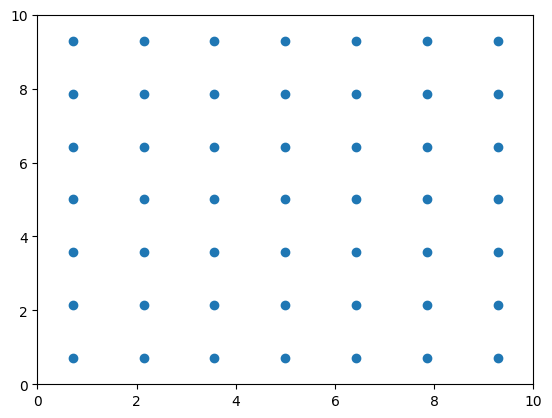

In [14]:
# Compute number of particles in one dimension of lattice
n_side = int(np.sqrt(n_particles))
if n_side**2 < n_particles: #check that all particles will fit
    n_side += 1

# Initialize positions in a regular lattice
positions = np.zeros((n_particles, 2))
for i in range(n_side): #loop over x direction
    for j in range(n_side): #loop over y direction
        if (i * n_side + j)<n_particles: # check if all particles have been placed yet
            #assign initial x and y position
            positions[i * n_side + j] = [(i + 0.5) * box_size / n_side, (j + 0.5) * box_size / n_side] 

#plot the initial positions
plt.figure(1)
plt.scatter(positions[:, 0], positions[:, 1]) #plot x and y positions of all particles
plt.xlim([0, box_size])
plt.ylim([0, box_size])
plt.show()


### Set the initial velocities of the particles
We will store the x and y components of the velocities in a 2D array called velocities. These are assigned randomly initially. 

In [4]:
# Initialize velocities from a Maxwell-Boltzmann distribution
velocities = np.random.normal(0, np.sqrt(temperature), (n_particles, 2))

## Lennard-Jones Potential
The Lennard-Jones potential is often used in molecular dynamics simulations to model simple liquids. It approximates the interaction between argon atoms.
$$
V(r) = 
4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right] 
$$
where $r$ is the distance between two particles.

The potential is plotted below. **What is the effect of changing the parameters $\sigma$ and $\epsilon$?**

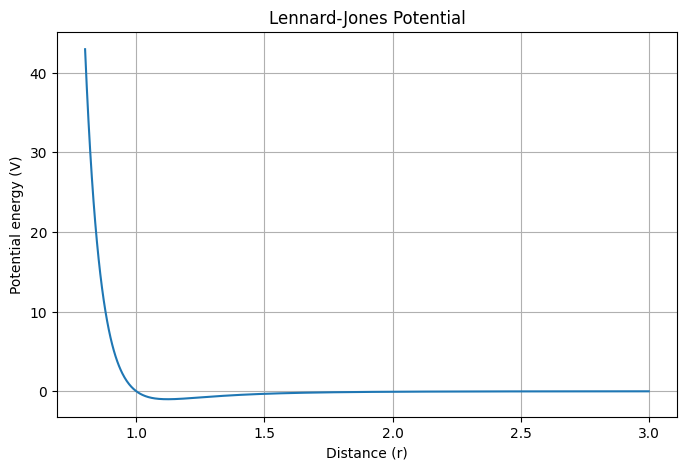

In [5]:
epsilon = 1.0 #constants that define potential 
sigma = 1.0

def lennard_jones_potential(r):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

#Make plot of potential as function of interparticle distance
# Generate values for r
r = np.linspace(0.8*sigma, 3*sigma, 1000)

# Calculate potential energy
V = lennard_jones_potential(r)

# Create the plot
plt.figure(2,figsize=(8, 5))
plt.plot(r, V, label='Lennard-Jones potential')
plt.title('Lennard-Jones Potential')
plt.xlabel('Distance (r)')
plt.ylabel('Potential energy (V)')
plt.grid(True)
plt.show()


The length scale and energy values in the simulation are often specified as multiples of $\sigma$ and $\epsilon$. **Reset these values to 1.** This is referred to as 'dimensionless' or 'reduced' units. The unit for time is then $ m\sigma^2 /\epsilon $, where $m$ is the particle mass.

We typically truncate the potential at some cut off distance to reduce computational time. The potential should also be shifted so that it is continuous at the cutoff point. 

In [6]:
def lennard_jones_potential_truncated(r):
    if r<2.5*sigma:
        return lennard_jones_potential(r) - lennard_jones_potential(2.5*sigma)
    else:
        return 0.0

We can calculate the total potential energy of the system by summing the interaction potential of all pairs of particles. **How does this change if the number of particles is decreased?**

In [7]:
def total_potential(pos):
    V_tot = 0.0
    # loop over all pairs of particles
    for i in range(n_particles): # loop over all particles
        for j in range(i): # loop over all particles with index less than 1st particle
            rij = pos[i] - pos[j] # vector between particles i and j
            rij = rij - np.round(rij / box_size) * box_size  # Apply periodic boundary conditions - find closest neighbour
            r = np.sqrt(rij[0]**2 + rij[1]**2) # distance betweeen particles
            V_tot += lennard_jones_potential_truncated(r) # calculate potential between i and j, add it to running total
    return V_tot

print(total_potential(positions))

-43.17453587044591


## Forces
The force one particle exerts on another is calculated from the derivative of the potential with respect to position.
$$
\mathbf{F} = -\nabla V(r)
$$
The force that j exerts on i is given by
$$
\mathbf{F}(r_{ij}) = \begin{cases}
\mathbf{r}_{ij} \frac{48\epsilon}{\sigma^2}\left[\left(\frac{\sigma}{r}\right)^{14}-\frac{1}{2}\left(\frac{\sigma}{r}\right)^{8}\right] & r\leq2.5\sigma \\
0 & r>2.5\sigma
\end{cases}
$$
where $\mathbf{r}_{ij}$ is the vector between particles i and j ($\mathbf{r}_{ij}=\mathbf{r}_{i}-\mathbf{r}_{j}$), and $r$ is the distance between these particles.
(extension question: Derive the above expression for the force.)

**Question:** What would happen at the cutoff distance if we didn't shift the potential?

**Write a function to calculate the force between two particles below.**

In [8]:
# function to calculate the force between a pair of particles (in either the x or y direction)
def calc_force_pair(rij):
    r = np.sqrt(rij[0]**2 + rij[1]**2) # distance between particles
    if r<2.5*sigma:
        return rij*48 * epsilon * ((sigma / r)**14 - 0.5*(sigma / r)**8)/sigma**2
    else:
        return rij*0.0

**Calculate the total force on each particle**

In [13]:
def calc_total_force(pos):
    force = np.zeros((n_particles, 2)) # make a 2D array to hold the x and y force on each particle
    # loop over all pairs of particles
    for i in range(n_particles): # loop over all particles
        for j in range(i): # loop over all particles with index less than 1st particle
            rij = pos[i] - pos[j] # vector between particles i and j
            rij = rij - np.round(rij / box_size) * box_size  # Apply periodic boundary conditions - find closest neighbour
            force_val = calc_force_pair(rij)
            force[i] += force_val #add force to running total for particle i
            force[j] -= force_val #equal and opposite force on each particle in pair
    return force


## Dynamics
The particles will move according to Newton's equations of motion.
$$
\mathbf{F}=m\mathbf{a}
$$
$\mathbf{F}$ is the force and $\mathbf{a}$ is the acceleration. For our simulations we will assume the particle mass $m = 1$ for all particles. If the positions, velocities and forces on all particles are known, we should be able to calculate how the position changes with time (remember, velocity is the derivative of position with time, and acceleration is the derivative of position with time). However, for more than two particles these equations become too complicated to solve analytically. Instead, we can solve them numerically with a computer. 

Newton’s equations of motion can be integrated numerically with the leapfrog algorithm:
$$
\mathbf{v}\left(t + \frac{\Delta t}{2}\right) = \mathbf{v}(t) + \frac{\Delta t}{2} \mathbf{a}(t) \\
\mathbf{x}(t + ∆t) = \mathbf{x}(t) + \Delta t \mathbf{v}\left(t + \frac{\Delta t}{2}\right) \\
\mathbf{v}(t + ∆t) = \mathbf{v}\left(t + \frac{\Delta t}{2}\right) + \frac{\Delta t}{2} \mathbf{a}(t + \Delta t))
$$
where $\Delta t$ is the time step length. 

**Write code to implement the leapfrog algorithm below.** Increment all particle positions and velocities by one time step in the loop below. Remember to apply the periodic boundary conditions after you move the particles. 

In [10]:
# set up lists to store output variables
positions_list = [positions.copy()]  # List to store positions
kinetic_energy = [] # List to store kinetic energy values
potential_energy = [] # List to store potential energy values
time_array = [] # List to store time values
time=0.0
# Calculate and record initial kinetic energy, potential energy
kinetic_energy.append(np.sum(0.5 * velocities**2))
potential_energy.append(total_potential(positions))
time_array.append(time)

# MAIN PART OF SIMULATION:
# Run molecular dynamics simulation
forces = calc_total_force(positions)
for i in range(timesteps):
    # Compute half-step velocity
    velocities += 0.5 * forces * dt
    # Compute new positions
    positions += velocities * dt
    positions = positions % box_size  # Apply periodic boundary conditions
    # Compute new forces
    forces_new = calc_total_force(positions)
    # Complete velocity step with new forces
    velocities += 0.5 * forces_new * dt
    forces = forces_new
    
    time += dt
    # store data for output
    if (i%10) == 0: # every 10 timesteps
        #store time
        time_array.append(time)
        # Calculate and record potential energy and kinetic energy
        kinetic_energy.append(np.sum(0.5 * velocities**2))
        potential_energy.append(total_potential(positions))
        # Store positions
        positions_list.append(positions.copy())

## Outputs

### Animation 
The positions of the particles are stored, in positions_list. These positions can be viewed in the animation below, by running that cell. View the animation. Is your simulation working?


In [11]:
# Create animation
fig, ax = plt.subplots()
ax.set_xlim([0, box_size])  # Set range of x-axis
ax.set_ylim([0, box_size])  # Set range of y-axis
scat = ax.scatter(positions_list[0][:, 0], positions_list[0][:, 1])

def update(frame):
    # Update plot with stored positions
    scat.set_offsets(positions_list[frame])
    return scat,

ani = FuncAnimation(fig, update, frames=range(len(positions_list)), interval=100, repeat=False)
plt.close(fig)
HTML(ani.to_jshtml())

### Energy 
The main loop above also stores the potential energy as the simulation runs, in the list potential_energy. This energy is plotted as a function of time by the code below. Run the code to view the plot.

**Write a function to calculate the kinetic energy of the system.** 
$$
KE = \frac{1}{2}\sum_i^N m \mathbf{v}_i^2
$$
Add this function to the main simulation loop, and store the value of the kinetic energy regularly. **Plot the kinetic energy on the Figure below**. Also plot the total energy. Is the total energy conserved? This is a common way to check if the simulation code is working. 

How long does it take your system to equilibrate?

**Change the value of the timestep, dt** (at the top of the script). How does this effect the energy conservation? 

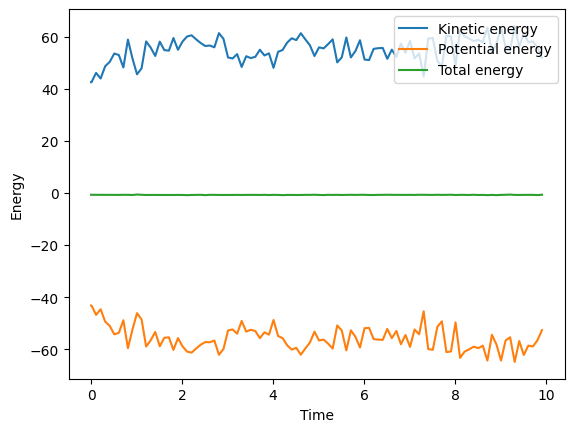

In [12]:
# Plot energy
plt.figure(4)
plt.plot(time_array, kinetic_energy, label="Kinetic energy") #plots line using time_array as x values, kinetic_energy as y values
plt.plot(time_array, potential_energy, label="Potential energy") #plots line using time_array as x values, potential_energy as y values
plt.plot(time_array, np.add(potential_energy,kinetic_energy), label="Total energy")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

## Part 2: Time reversibility
a)  Set dt = 0.001 and run your simulation for 1,000 timsteps. Then change dt to -0.001, and continue running your simulation for another 1,000 timesteps. This is equivalent to time running backwards. Plot the potential and kinetic energy throughout the process. **What do you observe?** View the x-y positions of the particles in the animation.



b) Repeat the simulation from a), however now, when reversing the timestep, also rotate the x-y direction of one particle's velocity by 10 degrees. **Explain your findings.**